In [90]:
import pandas as pd
import os
import time
import datetime 
from pandasql import sqldf
from uuid import uuid4
import mysql.connector
import warnings
import uuid as uuid_lib 
from dotenv import load_dotenv
from sqlalchemy import create_engine, MetaData, Table, select, text, update, DateTime, insert

Adjust the connection with your local connection

In [2]:
load_dotenv()
PASSWORD = os.getenv("PASSWORD")

In [3]:
# Replace 'username', 'password', 'hostname', 'database_name' with your MySQL credentials
username = 'root'
password = ''
hostname = 'localhost'
database_name = 'baltini_dummy'

In [4]:
# Create the connection string for MySQL
con = f'mysql+mysqlconnector://{username}:{password}@{hostname}/{database_name}'

In [5]:
# Create the SQLAlchemy engine
engine = create_engine(con)

In [6]:
engine.connect()

In [7]:
# Test the connection by trying to connect
try:
    connection = engine.connect()
    print("Connected to MySQL database!")
    connection.close()
except Exception as e:
    print(f"Error: {e}")

Connected to MySQL database!


# Test - check Brands table

In [8]:
query_brands = "SELECT * FROM brands"

# Read data into DataFrame
df_brands = pd.read_sql_query(query_brands, engine)

In [9]:
df_brands.head()

,id,name,created_at,updated_at,deleted_at
0,0009413d-b830-4805-93d6-4af6d94da171,STEWART,2023-09-28 17:11:31,2023-09-28 17:11:31,None
1,000e5de9-cce3-42d5-9cdb-4c8ba2304e67,RUS,2023-10-16 15:46:41,2023-10-16 15:46:41,None
2,0021ae64-2109-4e60-b0ba-3cb7309eabb4,MARC BY MARC,2023-10-16 16:04:19,2023-10-16 16:04:19,None
3,002332ee-d1c4-4a93-aab2-1801cc9d62a5,LUIGI BORRELLI NAPOLI,2023-10-16 17:20:54,2023-10-16 17:20:54,None
4,002d0e5f-e416-4875-a8a9-9375bfb8832a,ISOLA MARRAS,2023-09-28 17:12:09,2023-09-28 17:12:09,None


### Join notes
- product images join to products and suppliers with ids
- product options join to products with ids
- product variants join to products (id and external id), retailers, product images, 
- supplier id should be different


### Data exploration notes
to do the merging, potential columns that can be used
- title > could be different
- category > probably 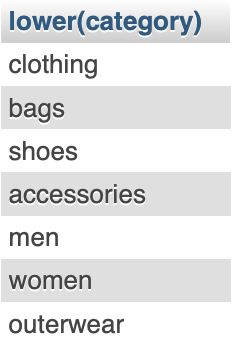 (the cleansing is not that good from the data source)
- gender > can be used
- product_type > can't be used since there is a potential missmatched. 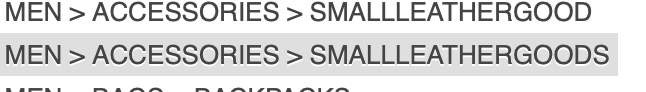
- external_product_code > probably can be used, no need to clean it since the code is unique
- external_id > unique
- brand_id > there is a double record 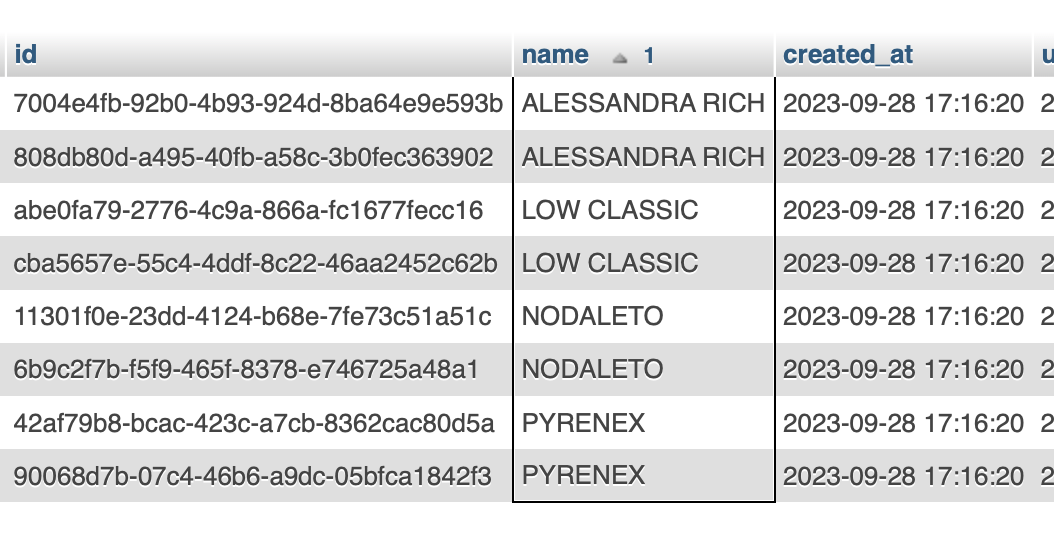
- season_id > is not standardized 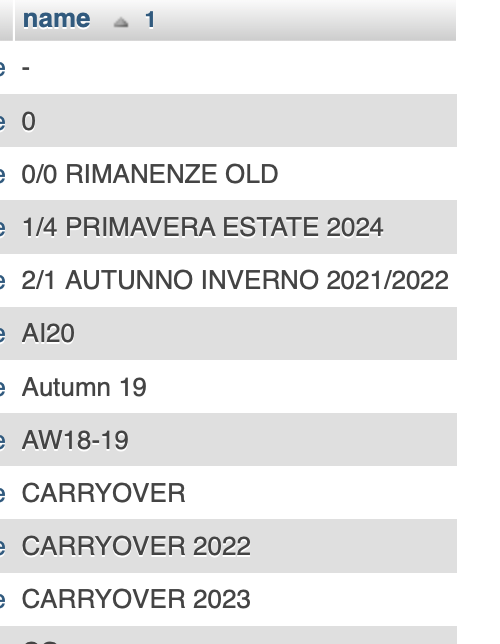
- sku > unique

# EXTRACTION

### Dump data into dataframe

In [10]:
def create_tbl(tbl_name, start_date, end_date):
    if start_date is None:
        query = f"SELECT * FROM {tbl_name} WHERE created_at is not null"
    else:
        query = f"SELECT * FROM {tbl_name} WHERE updated_at between '{start_date}' and '{end_date}'"
    
    df = pd.read_sql_query(query, engine).astype(str)
    
    return df

In [11]:
start_date = "2022-10-16"
end_date = "2023-12-13"
dim_date = None

df_products = create_tbl("products", start_date, end_date)
df_prod_variants = create_tbl("product_variants", start_date, end_date)
df_prod_options = create_tbl("product_options", start_date, end_date)
df_prod_images = create_tbl("product_images", start_date, end_date)
df_brands = create_tbl("brands", dim_date, dim_date)
df_seasons = create_tbl("seasons", dim_date, dim_date)

In [12]:
query_sql = '''

with product as (
    SELECT id, upper(title) as title, upper(category) as category, upper(gender) as gender, upper(product_type) as product_type, external_product_code, external_id, brand_id, season_id 
    FROM df_products
    WHERE 1
),

prod_variants as (
    SELECT product_id, supplier_id, external_id, cost_price_usd, retailer_id 
    FROM df_prod_variants 
    WHERE 1
),

prod_options as (
    SELECT product_id, `values` as option_value
    FROM df_prod_options
    WHERE 1
),

prod_images as (
    SELECT product_id, url, supplier_id
    FROM df_prod_images
    WHERE position=0
),

seasons as (
    SELECT id, upper(name) as name
    FROM df_seasons
),

brands as (
    SELECT id, upper(name) as name
    FROM df_brands
),

final as (
    select distinct p.*, 
        s.name as season_name,
        b.name as brand_name,
        pv.supplier_id, 
        pv.cost_price_usd, 
        pv.retailer_id,
        po.option_value,
        pi.url
    from product p 
    left join prod_variants pv 
    on p.id = pv.product_id

    left join prod_options po
    on p.id = po.product_id

    left join prod_images pi
    on pv.product_id = pi.product_id
    and pv.supplier_id = pi.supplier_id
    
    left join seasons s
    on s.id = p.season_id
    
    left join brands b 
    on b.id = p.brand_id

    where 1
)

select *
from final


'''

In [13]:
start_time = time.time()
result_sql = sqldf(query_sql)
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 51.8974 seconds


In [14]:
result_sql.head()

,id,title,category,gender,product_type,external_product_code,external_id,brand_id,season_id,season_name,brand_name,supplier_id,cost_price_usd,retailer_id,option_value,url
0,00000107-a486-4b91-802c-60f4db0ceb07,HOMME PLISSE T-SHIRTS & TOPS,CLOTHING,MEN,MEN > CLOTHING > TOPWEAR,HP36JK20332_Orange,652d5f49586def1f807ed888,7e0e05ae-b1c3-4e78-97fb-040994c12ece,21424889-061a-44f3-9e09-2fc8d3700f2d,SS23,HOMME PLISSÉ ISSEY MIYAKE,4ece0414-474c-4841-bdc0-1b8628821118,76.65,98ad78b2-04c3-4b16-826f-ed2255693632,"[""NUM 2"", ""NUM 3""]",https://storedimages.site/actives/HP36JK20332_...
1,000016d7-61bb-49d6-a01b-270a5298671b,VERSACE HANDBAGS,BAGS,MEN,MEN > BAGS > BACKPACKS,10077131A031901B00V_P23,652d5f21a35db4e0ced9f77a,e7cea7ae-3c4e-4532-b130-ff48863ad325,21424889-061a-44f3-9e09-2fc8d3700f2d,SS23,VERSACE,e8dd596f-5af0-4725-a90f-f08037ba002d,135.45,0e86b3da-f6a7-4711-ac08-547fb6556702,"[""UNICA""]",https://cdnhub.azureedge.net/foto/kraler/23008...
2,00002f64-1307-4a1a-810b-8b91dc69beda,AMBUSH SUEDE AND NYLON SNEAKERS,SHOES,MEN,MEN > SHOES > SNEAKERS,BMIA013F22LEA001_0310,652d4be7c5233a14a0ca9107,0b1a0349-0598-4eb8-ac51-4d864d60c340,76fa7003-95ae-4fe0-a046-9b095ebad3ec,FW22,AMBUSH,0b3267c7-42d8-4f1f-b65d-a19afdd8b42c,133.35,c1e39c17-37c9-429a-88fe-7135a1059e74,"[""IT 39"", ""IT 40"", ""IT 41"", ""IT 43"", ""IT 44"", ...",https://cdnfashion.activemss.eu/docs/reposImag...
3,00003e3e-3a19-4eac-a35b-a2311add7f65,BALENCIAGA DRESSES,CLOTHING,WOMEN,WOMEN > CLOTHING > DRESSES,725081TNO051000_P23,652d5f21a35db4e0ced9f67b,65d414d7-96f3-4c0f-b266-88ebdea73d82,fc01e155-4ebc-4792-9d9e-4ee0db88eb66,CARRYOVER,BALENCIAGA,e8dd596f-5af0-4725-a90f-f08037ba002d,1394.4,0e86b3da-f6a7-4711-ac08-547fb6556702,"[""F36"", ""F38""]",https://cdnhub.azureedge.net/foto/kraler/23008...
4,0000636f-e333-40ab-90a8-926c9cd92681,ALYX BRACELETS,ACCESSORIES,MEN,MEN > ACCESSORIES > JEWELRY,AAUJW0212OT01 GRY0002,652d4d13150a8842ce6be273,4b1718ac-28a5-458f-b38e-bae07a579ce8,21424889-061a-44f3-9e09-2fc8d3700f2d,SS23,1017 ALYX 9SM,aba9fbe1-9017-4d65-9d73-31aa2cd55d5c,116.55,cc13a3e6-931f-4d28-8540-91585266cf4f,"[""S/M"", ""L/XL""]",http://93.46.41.5:8080/GEB/2000009585940_1.jpg


In [15]:
result_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345814 entries, 0 to 345813
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   id                     345814 non-null  object
 1   title                  345814 non-null  object
 2   category               345814 non-null  object
 3   gender                 345814 non-null  object
 4   product_type           345814 non-null  object
 5   external_product_code  345814 non-null  object
 6   external_id            345814 non-null  object
 7   brand_id               345814 non-null  object
 8   season_id              345814 non-null  object
 9   season_name            345814 non-null  object
 10  brand_name             345814 non-null  object
 11  supplier_id            345814 non-null  object
 12  cost_price_usd         345814 non-null  object
 13  retailer_id            345814 non-null  object
 14  option_value           345814 non-null  object
 15  

# TRANSFORMATION / CLEANSING

In [16]:
query_agg = '''
SELECT category,
    gender,
    external_product_code, 
    brand_name, 
    season_name, 
    count(distinct supplier_id) as count_suppliers, 
    count(distinct retailer_id) as count_retailers
    
FROM result_sql
group by 1,2,3,4,5
order by 6 desc

'''

In [17]:
result_agg = sqldf(query_agg)
result_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304412 entries, 0 to 304411
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   category               304412 non-null  object
 1   gender                 304412 non-null  object
 2   external_product_code  304412 non-null  object
 3   brand_name             304412 non-null  object
 4   season_name            304412 non-null  object
 5   count_suppliers        304412 non-null  int64 
 6   count_retailers        304412 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 16.3+ MB


In [18]:
result_agg = result_agg[result_agg["count_suppliers"] > 1]

### Functions to merge duplicate products

In [24]:
# This function intends to get most popular title for duplicate products

def get_title(df):
    # Count distinct title for duplicate products
    grouped = df.groupby(['external_product_code', 'category', 'gender', 'season_name', 'brand_name', 'title']).size().reset_index(name='count_title')

    # Get the most popular title / rank=1
    grouped['rn'] = grouped.groupby(['external_product_code', 'category', 'gender', 'season_name', 'brand_name'])['count_title'].rank(method='first', ascending=False)
    result = grouped[grouped['rn'] == 1]

    # Displaying the final result
    final_result = result.drop('rn', axis=1)  # Dropping the 'rn' column 
    
    return final_result
   

In [25]:
# This column intends to get the source records to eventually replacing the title with the duplicate products group title

def cleansed(df1, df2):
    merged = pd.merge(
        df1,
        df2,
        on=['external_product_code', 'category', 'gender', 'season_name', 'brand_name'],
        how='inner'  
    )

    
    # Selecting specific columns 
    merged = merged[['id', 'title_y', 'external_id', 'external_product_code', 'category', 'gender', 'season_name', 'brand_name']]

    # Renaming columns
    merged = merged.rename(columns={'title_y': 'title'})
    
    return merged

In [26]:
# This funtion intends to execute all cleansing functions

def get_prod():
    result_sql['title'] = result_sql['title'].str.lower()

    # Get distinct external_product_code from result_agg df
    distinct_external_product_codes = result_agg['external_product_code'].unique()

    # Filtering result_sql based on external_product_code present in distinct_external_product_codes
    result = result_sql[result_sql['external_product_code'].isin(distinct_external_product_codes)]

    # Selecting specific columns 
    result = result[['id', 'title', 'external_id', 'external_product_code', 'category', 'gender', 'season_name', 'brand_name']]
    
    # Call funtions
    df_title = get_title(result)
    final_result = cleansed(result, df_title)
    
    return final_result

In [77]:
start_time = time.time()

df_dup = get_prod()

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 0.5696 seconds


# LOAD into product_duplicate_lists and product_duplicates

In [80]:
df_dup = df_dup.drop_duplicates()
df_agg_duplicates = df_dup.groupby(['title']).size().reset_index(name='count_products') 

In [83]:
df_agg_duplicates['id'] = ''
df_agg_duplicates['created_at'] = ''
df_agg_duplicates['updated_at'] = ''
df_dup['uuid'] = [str(uuid_lib.uuid4()) for _ in range(len(df_dup))]

In [84]:
duplicate_records = df_dup[df_dup.duplicated(subset=['id'], keep=False)]

In [85]:
duplicate_records

,id,title,external_id,external_product_code,category,gender,season_name,brand_name,uuid


In [86]:
metadata = MetaData(bind=engine)
tbl = Table('product_duplicates', metadata, autoload=True, autoload_with=engine)
tbl_list = Table('product_duplicate_lists', metadata, autoload=True, autoload_with=engine)

In [94]:
start_time = time.time()

# Suppress specific warning in a cell
pd.options.mode.chained_assignment = None 

for index, row in df_agg_duplicates.iterrows():
    row = row[['id','title','created_at','updated_at']]
    
    current_time = datetime.datetime.now()
    uuid_val = str(uuid_lib.uuid4())
    title = row['title']
    
    
    with engine.connect() as conn:
        data = {
            'id': uuid_val,
            'title': title,
            'created_at': current_time,
            'updated_at': current_time
        }
        
        sql_query = (
            "INSERT INTO product_duplicates (id, title, created_at, updated_at) "
            "VALUES (:id, :title, :created_at, :updated_at) "
            "ON DUPLICATE KEY UPDATE updated_at = VALUES(updated_at)"
        )
        
        df_list = df_dup[df_dup['title'] == title]
        df_list['product_duplicate_id'] = data['id']
        df_list['created_at'] = current_time
        df_list['updated_at'] = current_time
        df_list['deleted_at'] = None
        
        rename_col = {
            'uuid': 'id',
            'id': 'product_id'
        }
        
        df_list = df_list.rename(columns=rename_col)
        col = ['id','product_duplicate_id','external_id','product_id','deleted_at','created_at','updated_at']
        list_val = df_list[col]
       
        
        # Execute the statement
        conn.execute(text(sql_query), **data)
        try:
            # Attempt to insert the data
            list_val.to_sql(name='product_duplicate_lists', con=engine, if_exists='append', index=False)
        except Exception as e:
            continue
        
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.4f} seconds")
       

Elapsed time: 204.8163 seconds


In [103]:
# Question 2

start_date = "2023-12-10"
end_date = "2023-12-15"

query_pd = '''

    SELECT title as group_title, count(external_id) as product_counts, pd.updated_at 
    FROM product_duplicate_lists pl
    LEFT JOIN product_duplicates pd
    ON pl.product_duplicate_id = pd.id
    
    WHERE pl.created_at between '{start_date}' and '{end_date}'
    and pd.created_at between '{start_date}' and '{end_date}'
    
    GROUP BY 1,3

'''

## Notes & Proposal: 
- add external_product_code, category, gender, season name, and brand name in product_duplicates and product_duplicate_lists
- so we can identify the duplication faster without going through the transformation
- then, since the columns for identifying the duplication are not stored in either product_duplicates or product_duplicate_lists, there is a possibility that new data won't be identified as duplication whereas its group has been identified as duplication in product_duplicates and product_duplicate_lists 
- several records can not be read and written into product_duplicates due to duplicate entry error. (this is caused by the DB). solution > using datawarehouse or let developers handle the DB
- solution: alter table (ideal) or full scan table (costly)

## Important:
- Data engineer's scope is not altering / inserting / deleting data in DB, but we just extract the data from DB into datalake/datawarehouse
- If you don't have a plan to create a datalake/datawarehouse then it's better that you involve backend engineer to update the data in DB
- this project can be done in datawarehouse layer and consumed by BE engineer as well
- all partition, indexing, clustering to speed up the extraction is also set up in datalake/DWH layer. if you set it in DB, then it's BE's scope